# SMS Spam Classifier 

Project that classifies SMS messages as "spam" or "ham" (not spam) using Natural Language Processing (NLP) techniques. This project implements both manual Bag-of-Words feature extraction and scikit-learn's vectorizers for comparison.

## Import necessary libraries

In [70]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

## 1- Explore the data set

In [42]:
data = pd.read_csv("spam.csv", encoding='latin-1')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## 2- Clean the Dataframe

In [43]:
# merge v2, unnamed: 2, unnamed: 3 and unnamed: 4 into 1 column as some of them containes the rest of the text of v2
data['message'] = data['v2'] + ' ' + data['Unnamed: 2'].astype(str) +' ' + data['Unnamed: 3'].astype(str) + ' ' + data['Unnamed: 4'].astype(str)
data['message']
# convert spam and ham labels to binary (0 -> ham, 1 -> spam)
data['v1'] = data["v1"].map({"ham": 0, "spam": 1})
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   int64 
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
 5   message     5572 non-null   object
dtypes: int64(1), object(5)
memory usage: 261.3+ KB


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,message
0,0,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...,NaN,NaN,NaN,Ok lar... Joking wif u oni... nan nan nan
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...,NaN,NaN,NaN,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,"Nah I don't think he goes to usf, he lives aro..."


In [44]:
# select the required columns only (v1 and message)
data = data[['v1', 'message']]
# rename v1 to be spam
data = data.rename(columns={"v1": "spam"})
data.info()
print(f"Data shape after selecting the needed columns only: {data.shape}")
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   spam     5572 non-null   int64 
 1   message  5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB
Data shape after selecting the needed columns only: (5572, 2)


,spam,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni... nan nan nan
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## 3- Preprocess text data:
    - remove any special characters
    - lowercasing words
    - tokenize the message
    - remove stopwords
    - stemming

In [50]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to C:\Users\LAP
[nltk_data]     TECH\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to C:\Users\LAP
[nltk_data]     TECH\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt_tab to C:\Users\LAP
[nltk_data]     TECH\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [51]:
def preprocess_text(text):

    # remove eny special characters and numbers (keep only alpha charcaters)
    text = re.sub(r"[^a-z-A-Z\s]", '', text)

    # lowercase the text
    text = text.lower()

    # convert text into tokens
    tokens = word_tokenize(text)
    print(tokens[:5])

    # remove stopwords
    no_stops = [t for t in tokens if t not in stopwords.words('english')]

    # stem words (produce roots of words)
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(t) for t in no_stops]

    return ' '.join(stemmed_tokens)

# apply perpreocessing on the message column
data['processed_msg'] = data['message'].apply(preprocess_text)
data.head()

['go', 'until', 'jurong', 'point', 'crazy']
['ok', 'lar', 'joking', 'wif', 'u']
['free', 'entry', 'in', 'a', 'wkly']
['u', 'dun', 'say', 'so', 'early']
['nah', 'i', 'dont', 'think', 'he']
['freemsg', 'hey', 'there', 'darling', 'its']
['even', 'my', 'brother', 'is', 'not']
['as', 'per', 'your', 'request', 'melle']
['winner', 'as', 'a', 'valued', 'network']
['had', 'your', 'mobile', 'months', 'or']
['im', 'gon', 'na', 'be', 'home']
['six', 'chances', 'to', 'win', 'cash']
['urgent', 'you', 'have', 'won', 'a']
['ive', 'been', 'searching', 'for', 'the']
['i', 'have', 'a', 'date', 'on']
['xxxmobilemovieclub', 'to', 'use', 'your', 'credit']
['oh', 'kim', 'watching', 'here', 'nan']
['eh', 'u', 'remember', 'how', 'spell']
['fine', 'if', 'thats', 'the', 'way']
['england', 'v', 'macedonia', '-', 'dont']
['is', 'that', 'seriously', 'how', 'you']
['im', 'going', 'to', 'try', 'for']
['so', 'pay', 'first', 'lar', 'then']
['aft', 'i', 'finish', 'my', 'lunch']
['ffffffffff', 'alright', 'no', 'way', 'i'

,spam,message,processed_msg
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni... nan nan nan,ok lar joke wif u oni nan nan nan
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say nan nan nan
4,0,"Nah I don't think he goes to usf, he lives aro...",nah dont think goe usf live around though nan ...


## 4- Build custome Bag-of-Words model

* Build vocabulary

In [53]:
def build_vocab(messages):

    # counter object that will track how many times each word appears ex. {'fine':150, 'hi':10, ....}
    words_counts = Counter()

    for msg in messages:
        words = msg.split()
        words_counts.update(words)

    # create a vocab se containg most frequent words -> top(2000)
    # limit to 2000 to avoid too many features and reduce noise
    vocab = {word for word, count in words_counts.most_common(2000)}
    return vocab

vocabulary = build_vocab(data['processed_msg'])
print(vocabulary)

{'laugh', 'liao', 'often', 'nobodi', 'goodmorn', 'tho', 'bloke', 'sed', 'callin', 'nxt', 'everyth', 'uve', 'handl', 'near', 'predict', 'aunti', 'quiz', 'countri', 'leh', 'behav', 'sea', 'blank', 'sptyron', 'didt', 'landlin', 'list', 'send', 'detail', 'boss', 'fyi', 'stupid', 'il', 'cash-bal', 'wife', 'latr', 'chikku', 'pmsgrcvdhgsuitelandsrowwjhl', 'ym', 'true', 'faster', 'draw', 'mayb', 'smth', 'letter', 'broke', 'packag', 'sugar', 'femal', 'els', 'lose', 'e', 'ya', 'nt', 'poli', 'aunt', 'choic', 'quickli', 'ever', 'doesnt', 'wit', 'sat', 'street', 'forgot', 'blood', 'tt', 'xchat', 'kinda', 'laptop', 'ull', 'red', 'contact', 'q', 'breath', 'print', 'subscrib', 'ju', 'told', 'car', 'asap', 'believ', 'urgent', 'bare', 'mother', 'chechi', 'sm', 'exactli', 'gentleman', 'textoper', 'holiday', 'elsewher', 'bloodi', 'tampa', 'tonit', 'vikki', 'admir', 'morn', 'envelop', 'ach', 'star', 'sigh', 'medic', 'stylish', 'rose', 'noth', 'nokia', 'prepar', 'aight', 'away', 'anyth', 'caught', 'write', 

* Create feature Vectors

In [60]:
def manual_bow(msg, vocab):

    # create a zero vector with length on the vocabulary
    vector = [0] * len(vocab)

    # convert vocab set to a list to have fixed order
    vocab_list = list(vocab)

    # create a dictionary mapping each word to its position
    word_to_index = {word: idx for idx, word in enumerate(vocab_list)}

    for word in msg.split():
        # only count words we decided to keep -> top(2000)
        if word in word_to_index:
            vector[word_to_index[word]] += 1

    return vector

# create a 2D array where:
#   - each row represents 1 message
#   - each column represents a word in the vocabulary
#   - each cell represents the count of that word in this message
features_manual = np.array([manual_bow(msg, vocabulary) for msg in data['processed_msg']])
target_var = data['spam'].values

print("Features using Manual BOW model: ")
print(features_manual[:5])
print("Target Variable -> spam label: ")
print(target_var)

Features using Manual BOW model: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Target Variable -> spam label: 
[0 0 1 ... 0 0 0]


## 5- Model training with Custom Features

* Split the data

In [62]:
X_train, X_test, y_train, y_test = train_test_split(features_manual, target_var, test_size=0.2, random_state=42, stratify=target_var)

* Train models:
    - Logistic Regression model
    - Naive Bayes model

In [64]:
# Naive Bayes Classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)
naive_bayes_predictions = naive_bayes_classifier.predict(X_test)

# Logistic Regression Classifier
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_predictions = log_reg.predict(X_test)

## 6- Compare with scikit-learn's Vectorizer

In [72]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(data['processed_msg'])

X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tfidf, target_var, test_size=0.2, random_state=42, stratify=target_var)

naive_bayes_model_tfidf = MultinomialNB()
naive_bayes_model_tfidf.fit(X_train_tf, y_train_tf)
naive_bayes_tfidf_predictions = naive_bayes_model_tfidf.predict(X_test_tf)

## 7- Evaluate model performance

* Compare performance

In [73]:
print("Manual BOW Results: ")
print(f"Naive Bayes Accuracy: {accuracy_score(y_test, naive_bayes_predictions):.4f}")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, log_reg_predictions):.4f}")

print("Tfidf Results: ")
print(f"Naive Bayes Tfidf Accuracy: {accuracy_score(y_test_tf, naive_bayes_tfidf_predictions):.4f}")

Manual BOW Results: 
Naive Bayes Accuracy: 0.9812
Logistic Regression Accuracy: 0.9812
Tfidf Results: 
Naive Bayes Tfidf Accuracy: 0.9695


* Visualize results

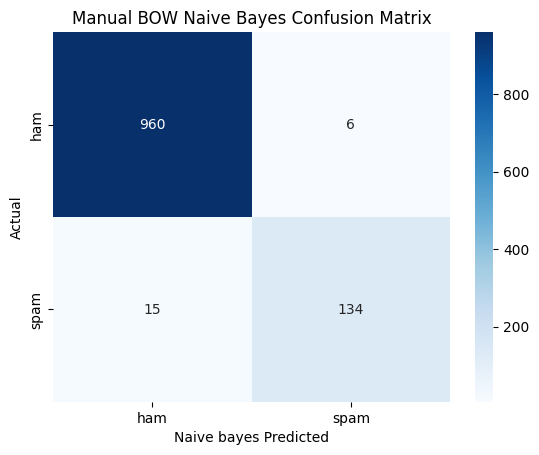

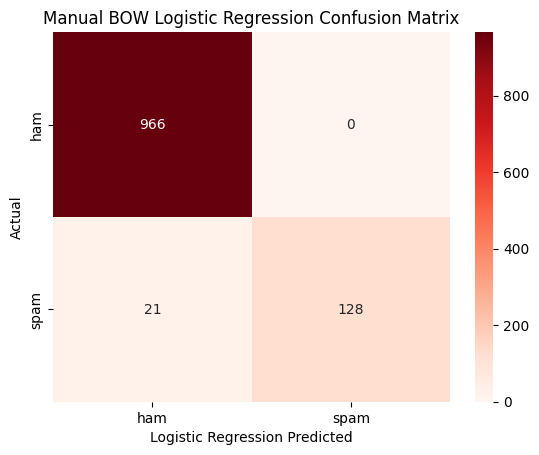

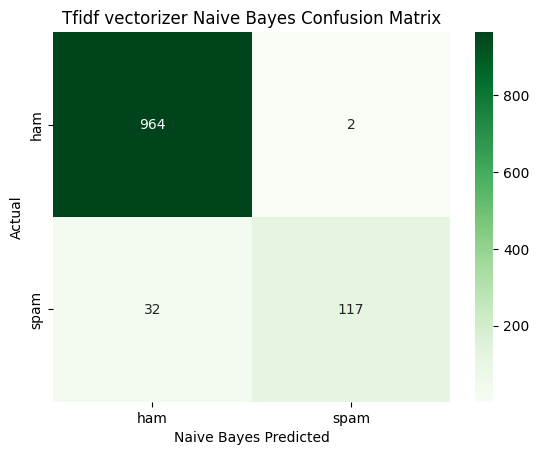

In [76]:
labels = ['ham', 'spam']

# Confusion matrix for naive bayes model
cm = confusion_matrix(y_test, naive_bayes_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Manual BOW Naive Bayes Confusion Matrix")
plt.xlabel('Naive bayes Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion matrix for logistic regression model
cm = confusion_matrix(y_test, log_reg_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.title("Manual BOW Logistic Regression Confusion Matrix")
plt.xlabel('Logistic Regression Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion matrix for tfidf naive bayes model
cm = confusion_matrix(y_test_tf, naive_bayes_tfidf_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.title("Tfidf vectorizer Naive Bayes Confusion Matrix")
plt.xlabel("Naive Bayes Predicted")
plt.ylabel('Actual')
plt.show()

## 8- Create a Prediction Function

In [79]:
def predict_spam(message, model, vectorizer):

    # clean the message
    cleaned_msg = preprocess_text(message)

    # Transform text into features
    features = vectorizer.transform([cleaned_msg])

    # predict
    prediction = model.predict(features)[0]
    probability = model.predict_proba(features)[0]

    return{
        "message": message,
        "is-spam": bool(prediction),
        "spam-probability": probability[1],
        "ham-probability" : probability[0]
    }

test_messages = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim.",
    "Hey, are we still meeting for lunch tomorrow?",
    "URGENT: Your bank account has been suspended. Verify your identity now."
]

for msg in test_messages:
    result = predict_spam(msg, naive_bayes_model_tfidf, tfidf_vectorizer)
    print(f"Message: {result['message']}")
    print(f"Spam: {result['is-spam']} (Confidence: {result['spam-probability']:.2%})")
    print("---")


['congratulations', 'youve', 'won', 'a', 'walmart']
Message: Congratulations! You've won a $1000 Walmart gift card. Click here to claim.
Spam: True (Confidence: 76.80%)
---
['hey', 'are', 'we', 'still', 'meeting']
Message: Hey, are we still meeting for lunch tomorrow?
Spam: False (Confidence: 0.53%)
---
['urgent', 'your', 'bank', 'account', 'has']
Message: URGENT: Your bank account has been suspended. Verify your identity now.
Spam: True (Confidence: 65.12%)
---
